### Preprocess iEEG dataset

### 1. discard bad channels
### 2. notch filter for line noise
### 3. common average reference(raw_car)


In [1]:
class SubjectDataset(object):
    def __init__(self, input_root, subject, preload=True, **kwargs):
        self.root = input_root
        self.subject = subject
        self.datatype = 'ieeg'
        self.acquisition = None
        self.__dict__.update(kwargs)
        self.task = 'film'
        self.expected_duration = 390


        if preload:
            self._set_paths()
            self._load_data()
            self._get_bad_electrodes()
            
    def _set_paths(self):
        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      task=self.task,
                                      suffix='ieeg',
                                      extension='vhdr',
                                      datatype=self.datatype,
                                      acquisition=self.acquisition,
                                      root=self.root)

        print(self.task)
        assert len(bids_path.match()) == 1, 'None or more than one run for task is found'

        self.raw_path = str(bids_path.match()[0])
        self.run = mne_bids.get_entities_from_fname(bids_path.match()[0])['run']
        self.session = mne_bids.get_entities_from_fname(bids_path.match()[0])['session']

        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      task=self.task,
                                      session=self.session,
                                      suffix='channels', run=self.run,
                                      extension='tsv',
                                      datatype=self.datatype,
                                      acquisition=self.acquisition,
                                      root=self.root)
        self.channels_path=str(bids_path)

        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      session=self.session, suffix='electrodes',
                                      extension='tsv',
                                      datatype=self.datatype,
                                      acquisition=self.acquisition,
                                      root=self.root)
        self.electrodes_path = str(bids_path)

        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      suffix='T1w',
                                      extension='.nii.gz',
                                      root=self.root)
        self.anat_path = str(bids_path.match()[0])
        self.anat_session = mne_bids.get_entities_from_fname(bids_path.match()[0])['session']
        print('Picking up BIDS files done')


    def _load_data(self):
        self.raw = mne.io.read_raw_brainvision(self.raw_path,
                                               eog=(['EOG']),
                                               misc=(['OTHER', 'ECG', 'EMG']),
                                               scale=1.0,
                                               preload=False,
                                               verbose=True)
        self.channels = pd.read_csv(self.channels_path, sep='\t', header=0, index_col=None)
        self.electrodes = pd.read_csv(self.electrodes_path, sep='\t', header=0, index_col=None)
        self.raw.set_channel_types({ch_name: str(x).lower()
                                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                    for ch_name, x in zip(self.raw.ch_names, self.channels['type'].values)})
        self.other_channels = self.channels['name'][~self.channels['type'].isin(['ECOG', 'SEEG'])].tolist()
        self.raw.drop_channels(self.other_channels)
        print('Loading BIDS data done')


    def _get_bad_electrodes(self):
        self.bad_electrodes = self.channels['name'][
            (self.channels['type'].isin(['ECOG', 'SEEG'])) & (self.channels['status'] == 'bad')].tolist()
        self.all_electrodes = self.channels['name'][(self.channels['type'].isin(['ECOG', 'SEEG']))].tolist()
        print('Getting bad electrodes done')

        
    def preprocess(self):
        raw_dbe=self._discard_bad_electrodes()
        raw_nf=self._notch_filter()
        raw_car=self._common_average_reference()
        return raw_car


    def _discard_bad_electrodes(self):
        if self.raw is not None:
            [self.bad_electrodes.remove(i) for i in self.bad_electrodes if i not in self.raw.ch_names]
            self.raw.info['bads'].extend([ch for ch in self.bad_electrodes])
            print('Bad channels indicated: ' + str(self.bad_electrodes))
            print('Dropped ' + str(self.raw.info['bads']) + 'channels')
            self.raw.drop_channels(self.raw.info['bads'])
            self.raw.load_data()
            print('Remaining channels ' + str(self.raw.ch_names))
            return self.raw


    def _notch_filter(self):
        if self.raw is not None:
            if np.any(np.isnan(self.raw._data)):
                # self.raw._data[np.isnan(self.raw._data)]=0 # bad hack for nan values
                warnings.warn('There are NaNs in the data, replacing with 0')
            self.raw.notch_filter(freqs=np.arange(50, 251, 50))
            print('Notch filter done')
        return self.raw


    def _common_average_reference(self):
        if self.raw is not None:
            self.raw_car, _ = mne.set_eeg_reference(self.raw.copy(), 'average')
            print('CAR done')
        return self.raw_car


    def extract_events(self, plot=True):
        events,events_id=self._read_events()
        if plot:
            self._plot_events()
        return events,events_id


    def _read_events(self):
        if self.raw is not None:
            if self.task == 'film':
                custom_mapping = {'Stimulus/music': 2,
                                  'Stimulus/speech': 1,
                                  'Stimulus/end task': 5}
            elif self.task == 'rest':
                custom_mapping = {'Stimulus/start task': 1,
                                  'Stimulus/end task': 2}
            else:
                raise NotImplementedError
            self.events, self.event_id = mne.events_from_annotations(self.raw, event_id=custom_mapping,
                                                                     use_rounding=False)
            print('Reading events done')
        return self.events, self.event_id


    def _plot_events(self):
        if self.raw_car is not None:
            self.raw_car.plot(events=self.events,
                              start=0,
                              duration=180,
                              color='gray',
                              event_color={2: 'g', 1: 'r'},
                              bgcolor='w')


    def extract_bands(self, smooth=False):
        if self.raw_car is not None:
            bands2=self._compute_band_envelopes()
            bands3=self._crop_band_envelopes()
            bands4=self._resample_band_envelopes()
            if smooth: self._smooth_band_envelopes()
            bands5,bands6,band_block_means=self._compute_block_means_per_band()
        return bands2,bands3,bands4,bands5


    def _compute_band_envelopes(self):
        if self.raw_car is not None:
            bands = {'delta': [1, 4], 'theta': [5, 8], 'alpha': [8, 12], 'beta': [13, 24], 'gamma': [60, 120]}
            self.bands1 = OrderedDict.fromkeys(bands.keys())
            for key in self.bands1.keys():
                self.bands1[key] = self.raw_car.copy().filter(bands[key][0], bands[key][1]).apply_hilbert(
                    envelope=True).get_data().T
            print('Extracting band envelopes done')
        return self.bands1


    def _crop_band_envelopes(self):
        if self.bands1 is not None:
            self.bands2 = OrderedDict.fromkeys(self.bands1.keys())
            for key in self.bands1.keys():
                self.bands2[key] = self.bands1[key][self.events[0, 0]:self.events[-1, 0]]
        return self.bands2


    def _resample_band_envelopes(self):
        if self.bands1 is not None:
            self.bands3 = OrderedDict.fromkeys(self.bands1.keys())
            for key in self.bands1.keys():
                self.bands3[key] = resample(self.bands2[key], 25, int(self.raw.info['sfreq']))
        return self.bands3



    def _smooth_band_envelopes(self):
        if self.bands1 is not None:
            for key in self.bands1.keys():
                self.bands[key] = np.apply_along_axis(smooth_signal, 0, self.bands[key], 5)


    def _compute_block_means_per_band(self):
        if self.bands1 is not None:
            self.band_block_means = OrderedDict.fromkeys(self.bands1.keys())
            band6=OrderedDict.fromkeys(self.bands1.keys())
            for key in self.bands1.keys():
                band6[key] = zscore(self.bands3[key][:self.expected_duration * 25])
                band7 = band6[key].reshape((-1, 750, band6[key].shape[-1]))  # 13 blocks in chill or 6 in rest
                self.band_block_means[key] = np.mean(band7, 1)
        return band6,band7,self.band_block_means
        

### read all patient and save raw data of all patients(raw_car_all) and gamma band of all patients(band_all_patient)

### 1. extract signal in five frequency bands (Hilbert transform, take envelope): delta, theta, alpha, beta nad high broadband gamma

### 2. downsample to 25 Hz

### definition output:
### 3.bands2= output of "def _compute_band_envelopes" contains each band in fs=2048 & time duration =420s
### 4.bands3= output of "def  _crop_band_envelopes" contains each band in fs=2048 & time duration =390s
 
note= time duration of raw signal is 420s but time duration of raw film is 390s so by "def _crop_band_envelopes", time of signal correct

### 5.bands4= output of "def  _resample_band_envelopes" contains each band in fs=25 & time duration =420s
### 6.bands5=output of "def  _compute_block_means_per_band" calculate Zscore of singal in each bands


In [ ]:
import mne_bids
import mne
import pandas as pd
import os
import numpy as np
from collections import OrderedDict
from ieeg_fmri_validation.utils import resample, smooth_signal, zscore

num=63
bids_dir='E:\maryam.sh'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
subject=subjects[0]
acqs=mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject, 'ses-iemu', 'ieeg'),'acquisition')
acq=acqs[0]
band_all_patient=[]
raw_car_all=[]
i=0
subjects2=subjects[:num]
for subject in subjects2:
     if 'iemu' in mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject), 'session'):
        i=i+1
        s=SubjectDataset(bids_dir,subject,acquisition=acq)
        raw_car=s.preprocess()
        events,events_id=s.extract_events()
        bands2,bands3,bands4,band5=s.extract_bands()
        band_all_patient.append(band5['gamma'])
        raw_car_all.append(raw_car)
    
    

### save and load band_all_patient and raw_car_all

In [34]:
import pickle 

with open('rr.txt','wb') as f:
    pickle.dump(band_all_patient,f)

#with open('rr.txt','rb') as f:
#    band_all_patient=pickle.load(f)
    
#with open('raw_car_all.txt','wb') as f:
#    pickle.dump(raw_car_all,f)
    
#with open('raw_car_all.txt','rb') as f:
#    raw_car_all=pickle.load(f)

### calculate histogram of electrodes of patients(h)

In [25]:
import matplotlib.pyplot as plt
from collections import Counter

d=[]
for i in range(len(raw_car_all)):
    elec_list=raw_car_all[i].ch_names
    d=[*d,*elec_list]
    
#plt.figure(figsize=(30,10))    
#plt.hist(d)
#plt.show()

h=Counter(d)


In [27]:
h.elements

<bound method Counter.elements of Counter({'T01': 23, 'T04': 23, 'T05': 23, 'T07': 23, 'T02': 22, 'T03': 22, 'T06': 22, 'T08': 20, 'T09': 19, 'T10': 19, 'T11': 19, 'T12': 19, 'T13': 19, 'T14': 19, 'F01': 16, 'F03': 16, 'F05': 16, 'F06': 16, 'F07': 16, 'F08': 16, 'T15': 16, 'F02': 15, 'F04': 15, 'F11': 14, 'F12': 14, 'F13': 14, 'F14': 14, 'F15': 14, 'F16': 14, 'sT1': 14, 'sT2': 14, 'sT3': 14, 'sT4': 14, 'T16': 14, 'vT1': 14, 'vT3': 14, 'vT4': 14, 'vT6': 14, 'F09': 13, 'F10': 13, 'F17': 13, 'F18': 13, 'F19': 13, 'F20': 13, 'F21': 13, 'F22': 13, 'F23': 13, 'F24': 13, 'F28': 13, 'F30': 13, 'F31': 13, 'sT5': 13, 'T18': 13, 'T19': 13, 'T20': 13, 'T21': 13, 'T22': 13, 'T23': 13, 'T25': 13, 'T26': 13, 'T27': 13, 'T28': 13, 'T30': 13, 'T31': 13, 'T32': 13, 'vT2': 13, 'vT5': 13, 'F27': 12, 'F29': 12, 'F32': 12, 'T17': 12, 'T24': 12, 'T29': 12, 'F25': 11, 'F26': 11, 'vT7': 11, 'C01': 10, 'C02': 10, 'C03': 10, 'C04': 10, 'C05': 10, 'C06': 10, 'C07': 10, 'F33': 9, 'F34': 9, 'F35': 9, 'F36': 9, 'F37

In [58]:
elec_more_one=[]
elec_more_ten=[]
elec_more_fifteen=[]
elec_more_tweny=[]
elec_more_thirty=[]


for key in h.keys():
    if(h[key]>1):
        elec_more_one.append(key) 
    if(h[key]>10):
        elec_more_ten.append(key)
    if(h[key]>15):
        elec_more_fifteen.append(key)
    if(h[key]>20):
        elec_more_tweny.append(key)
   
    

print('number of total electrode is =' , len(h) ,'\nmax number of electrod is same=',23)    

print('number of electrod that are same in more than one patient = ', len(elec_more_one))
print('number of electrod that are same in more than ten patient = ' ,len(elec_more_ten))
print('number of electrod that are same in more than fifteen patient = ' ,len(elec_more_fifteen))
print('number of electrod that are same in more than tweny patient = ', len(elec_more_tweny))


print('\n\n',elec_more_fifteen,'elec_more_fifteen\n\n')

print(elec_more_tweny,'elec_more_tweny')

number of total electrode is = 1522 
max number of electrod is same= 23
number of electrod that are same in more than one patient =  540
number of electrod that are same in more than ten patient =  76
number of electrod that are same in more than fifteen patient =  21
number of electrod that are same in more than tweny patient =  7


 ['F01', 'F03', 'F05', 'F06', 'F07', 'F08', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T08', 'T15'] elec_more_fifteen


['T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07'] elec_more_tweny


### find index of patients who have common electrodes

In [126]:
elec= {'F01':[] , 'F03':[] , 'F05': [] , 'F06':[] , 'F07':[] , 'F08':[] , 'T01':[] , 'T02':[] , 'T03':[] , 'T04':[] , 'T05':[] , 'T06':[], 'T07':[], 'T09':[], 'T10':[], 'T11':[], 'T12':[], 'T13':[], 'T14':[], 'T08':[], 'T15':[]}

for i in range(len(raw_car_all)):
    for key in elec.keys():
        if key in raw_car_all[i].ch_names:
            elec[key].append(i)

for key in elec.keys():
    print('\n  ' ,key, '=', elec[key])


   F01 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F03 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F05 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F06 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F07 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F08 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   T01 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T02 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T03 = [2, 3, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T04 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T05 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T06 = [2, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 

### plot average gamma band for common electrodes

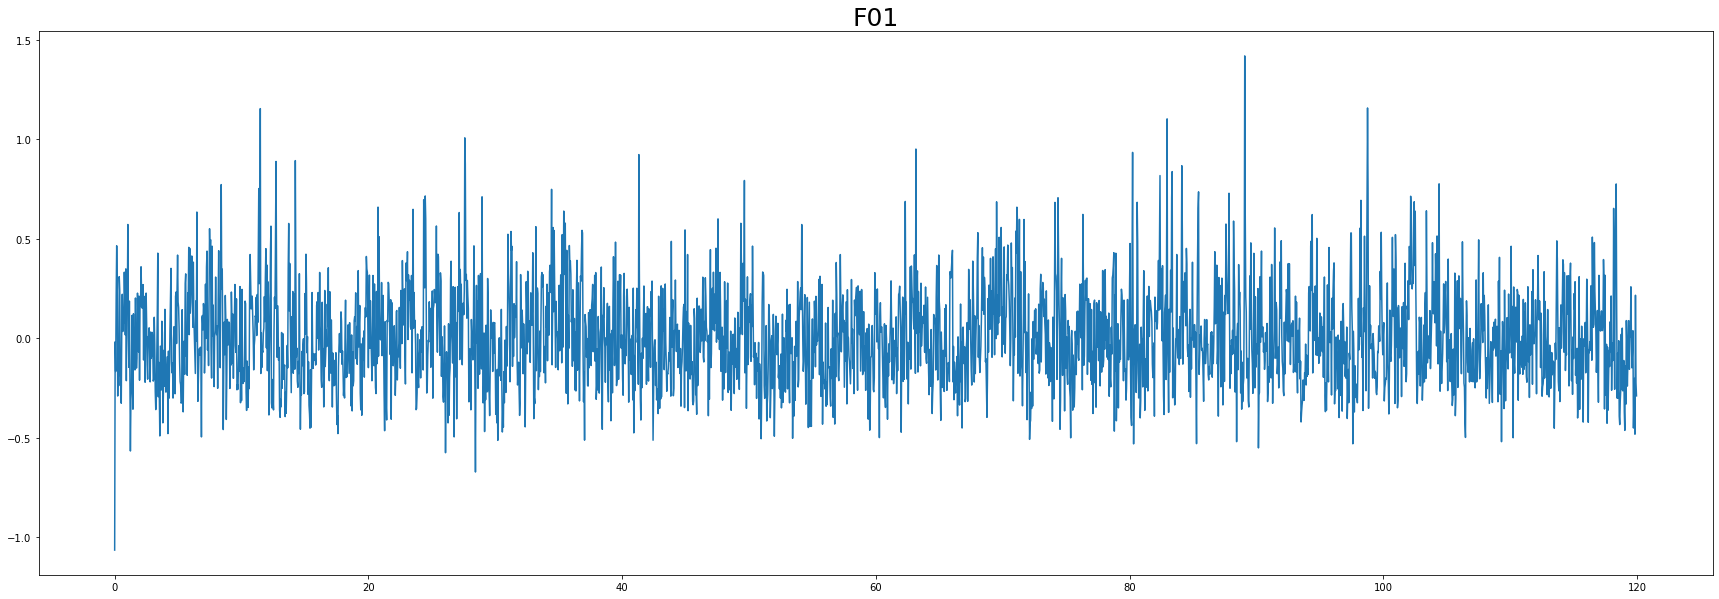

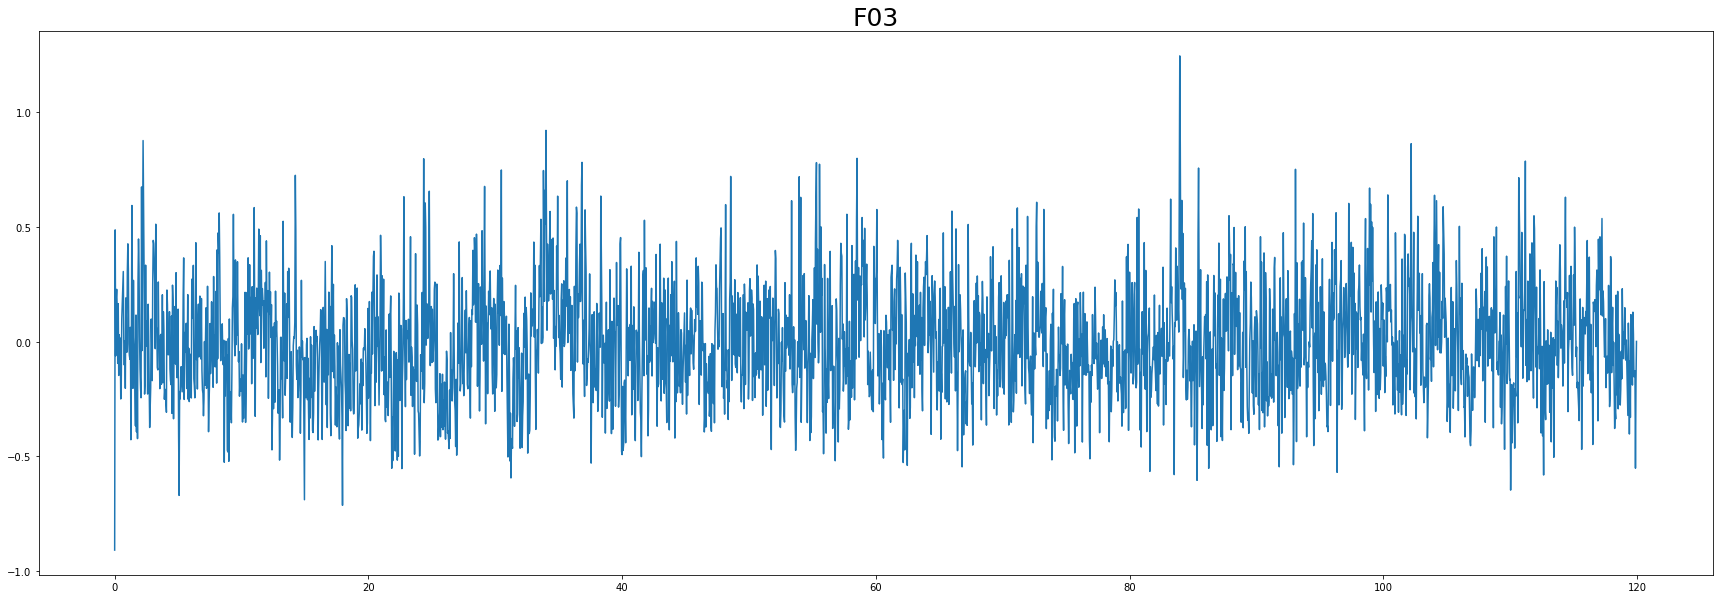

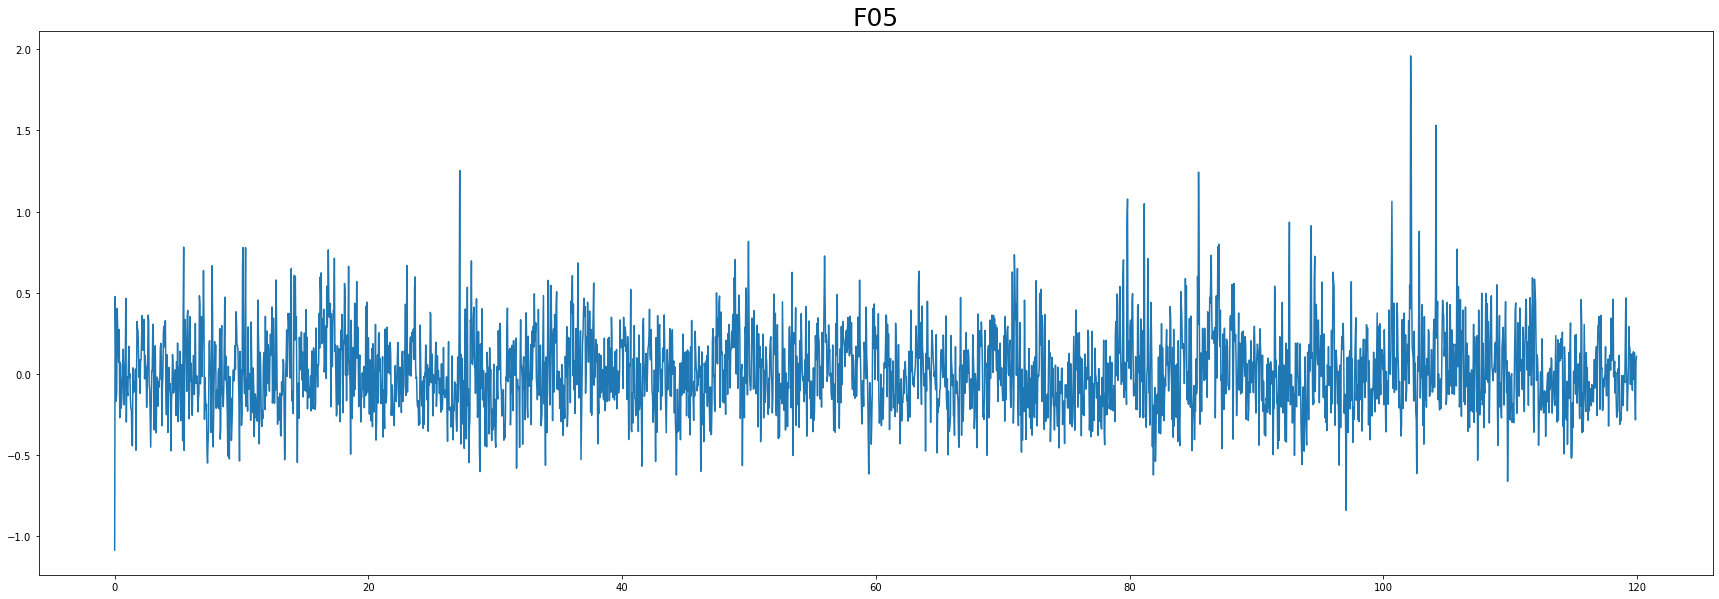

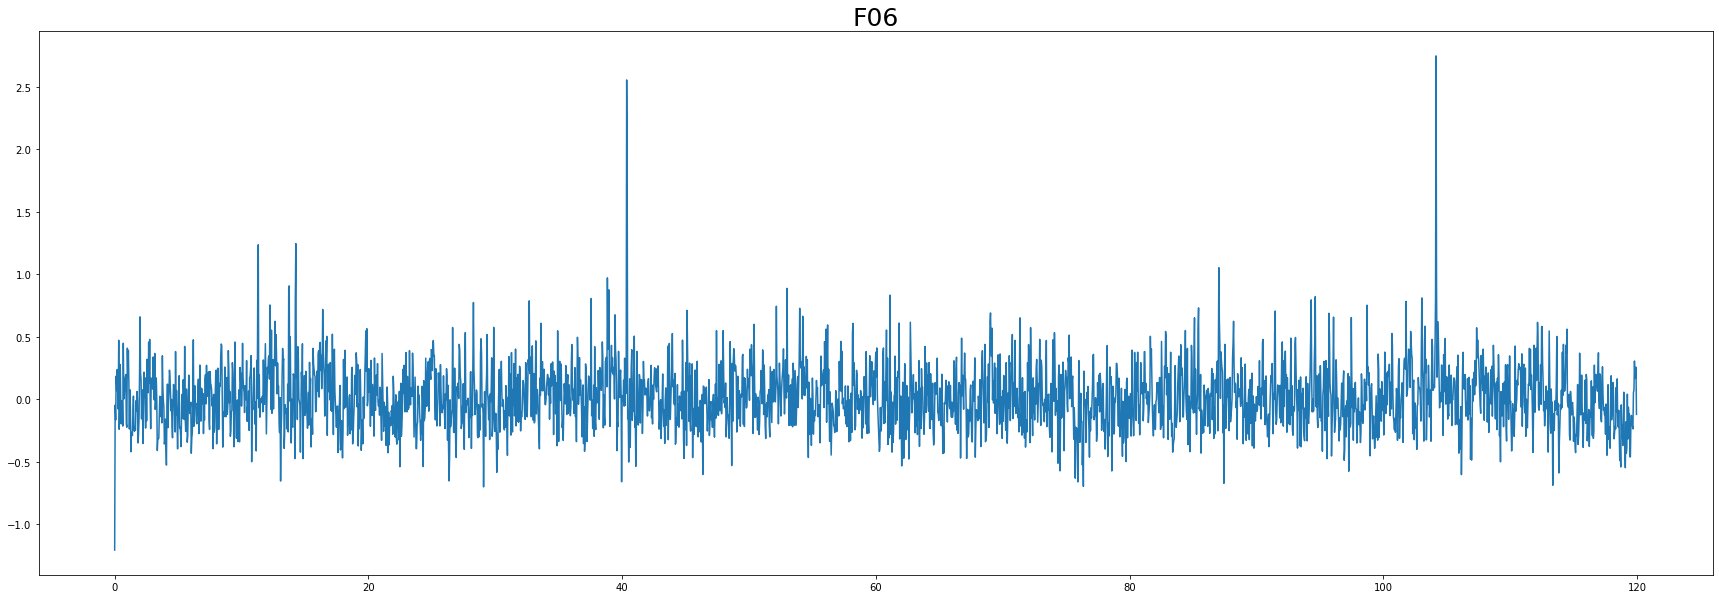

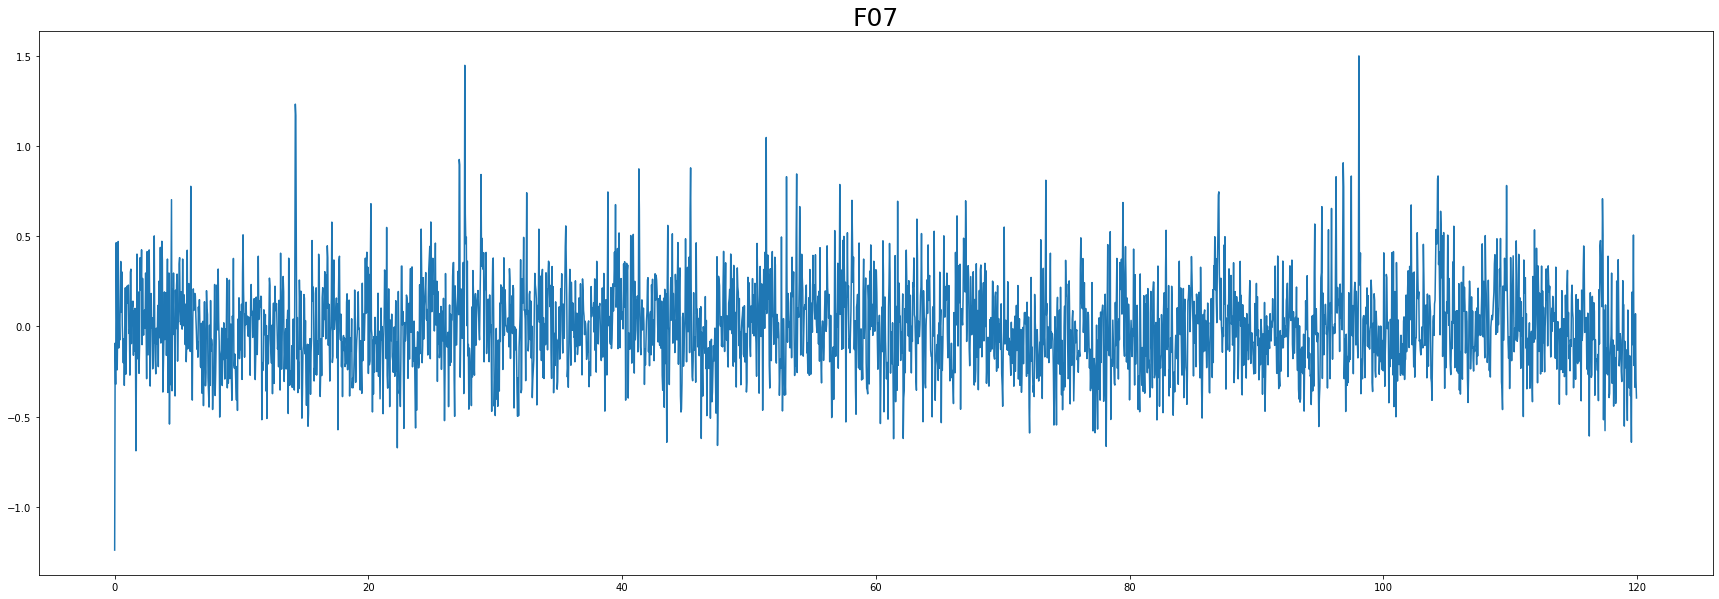

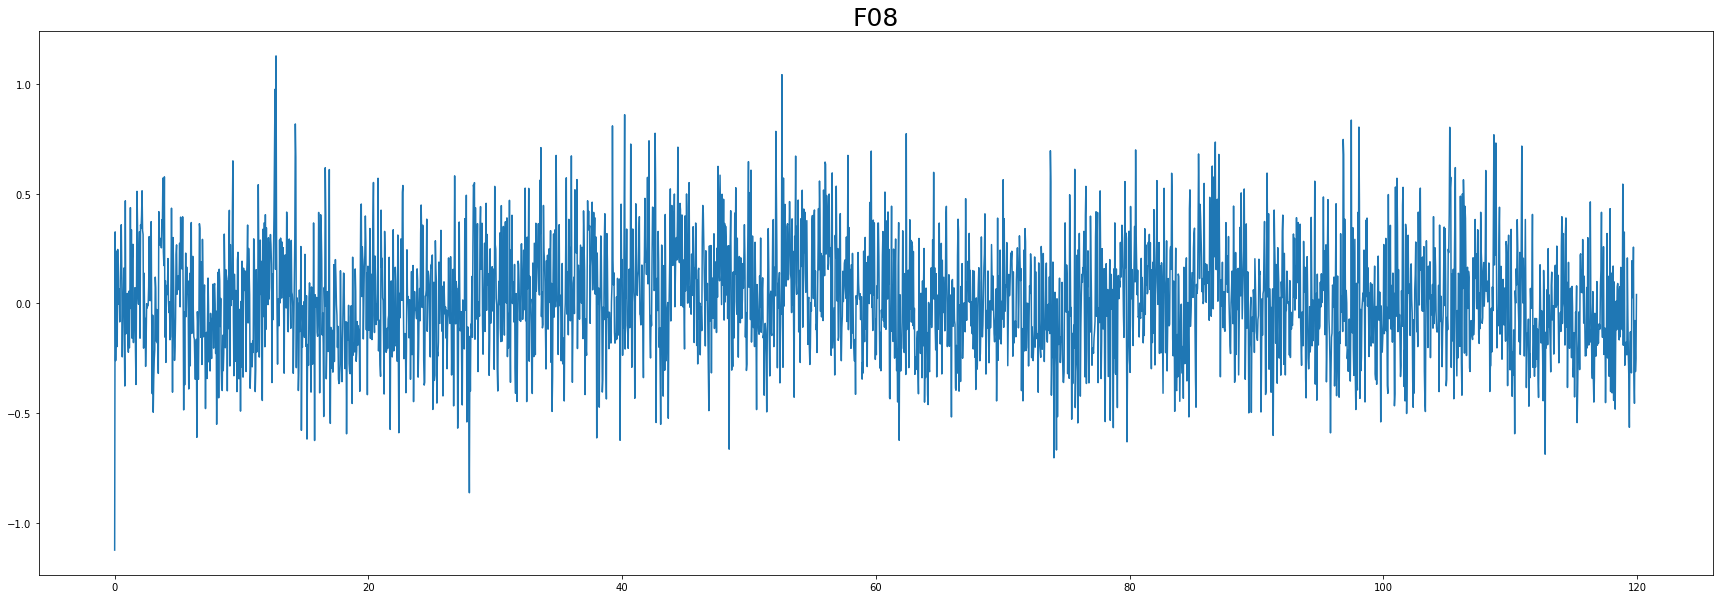

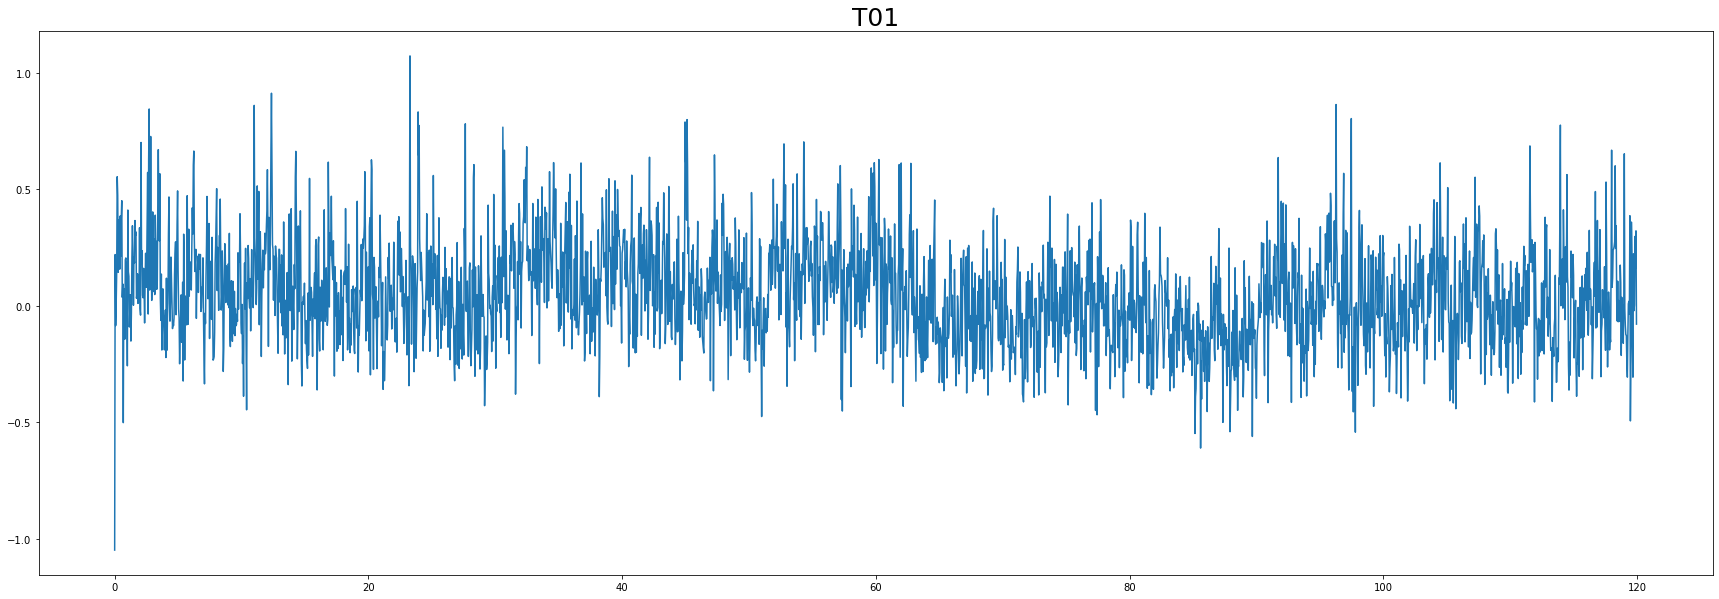

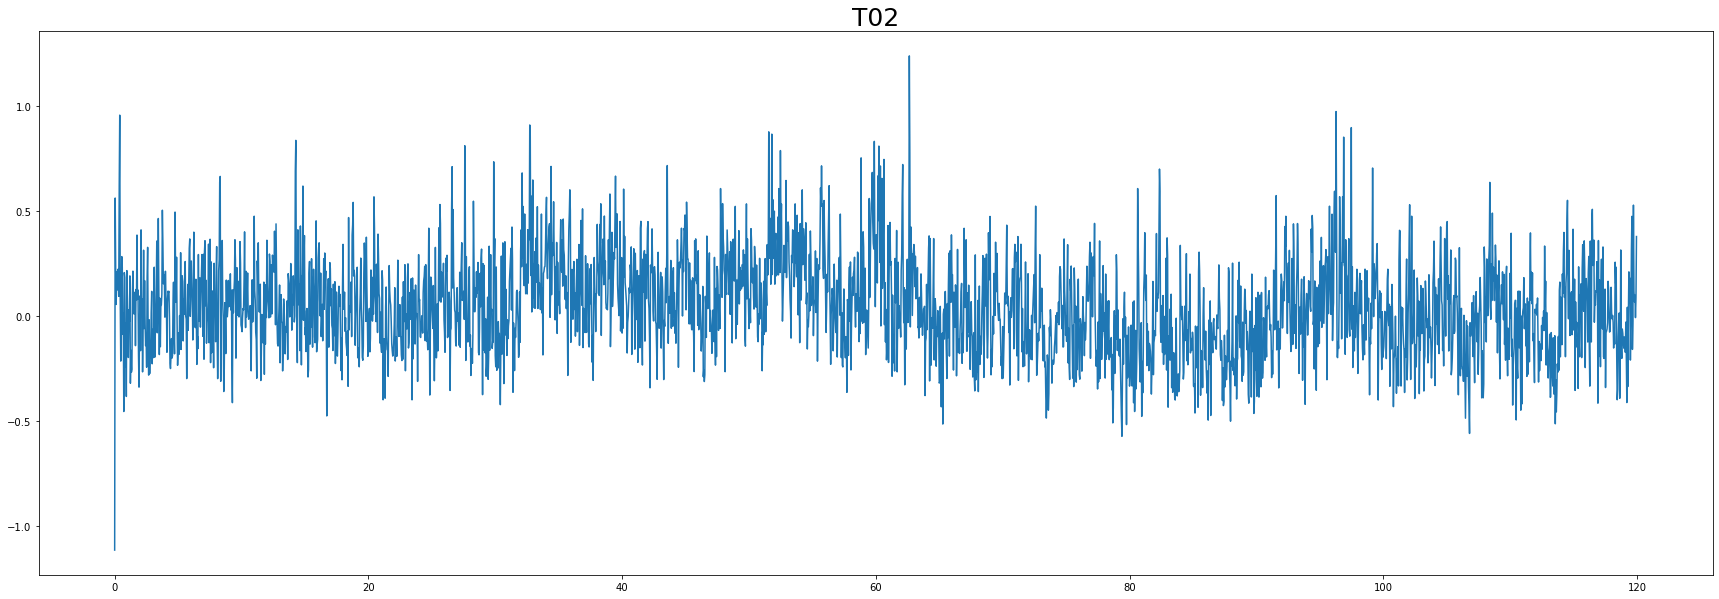

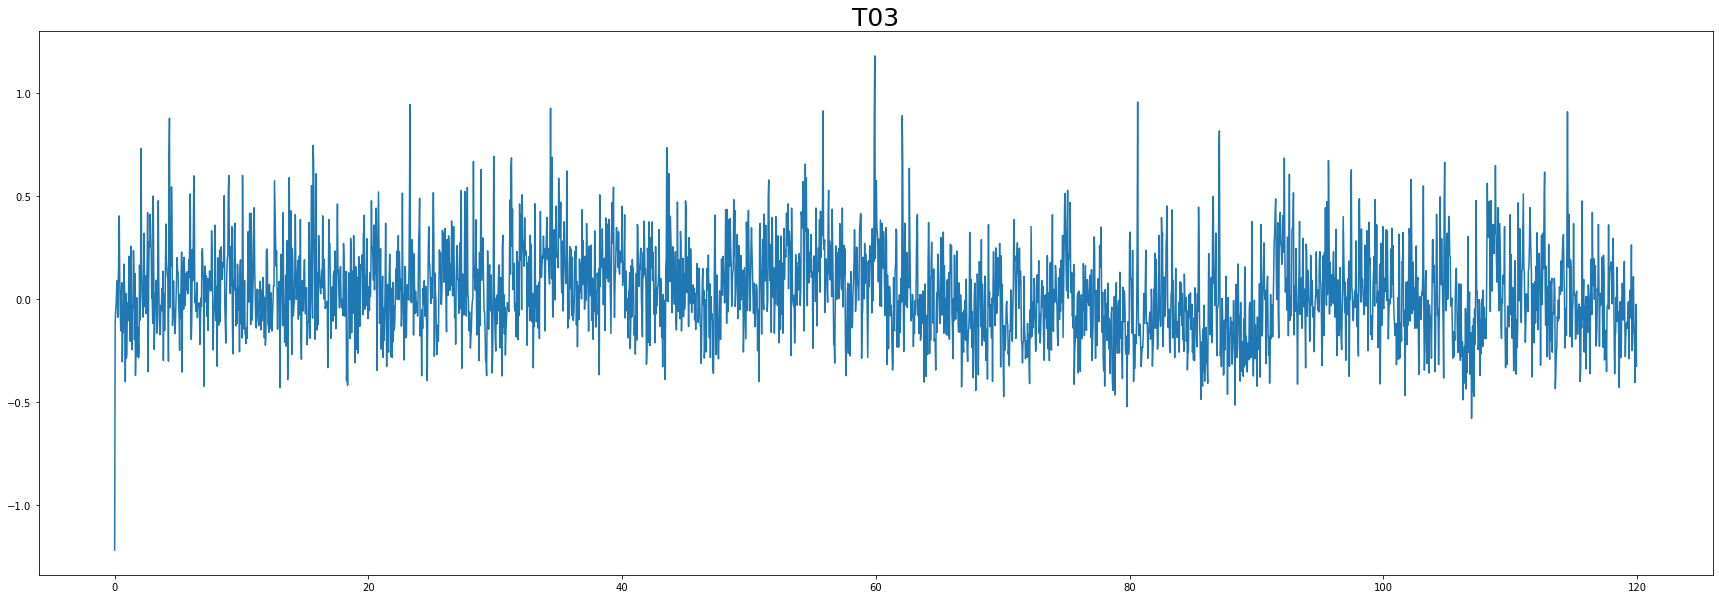

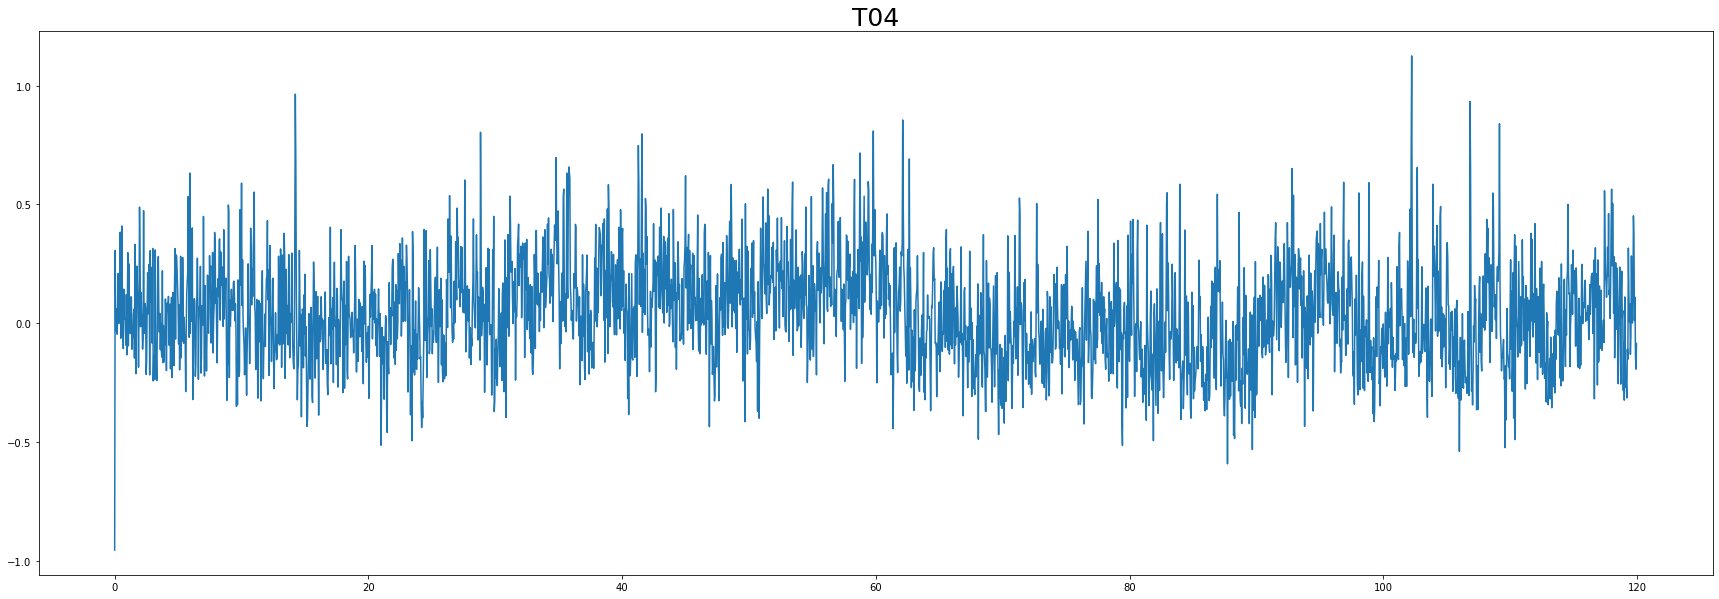

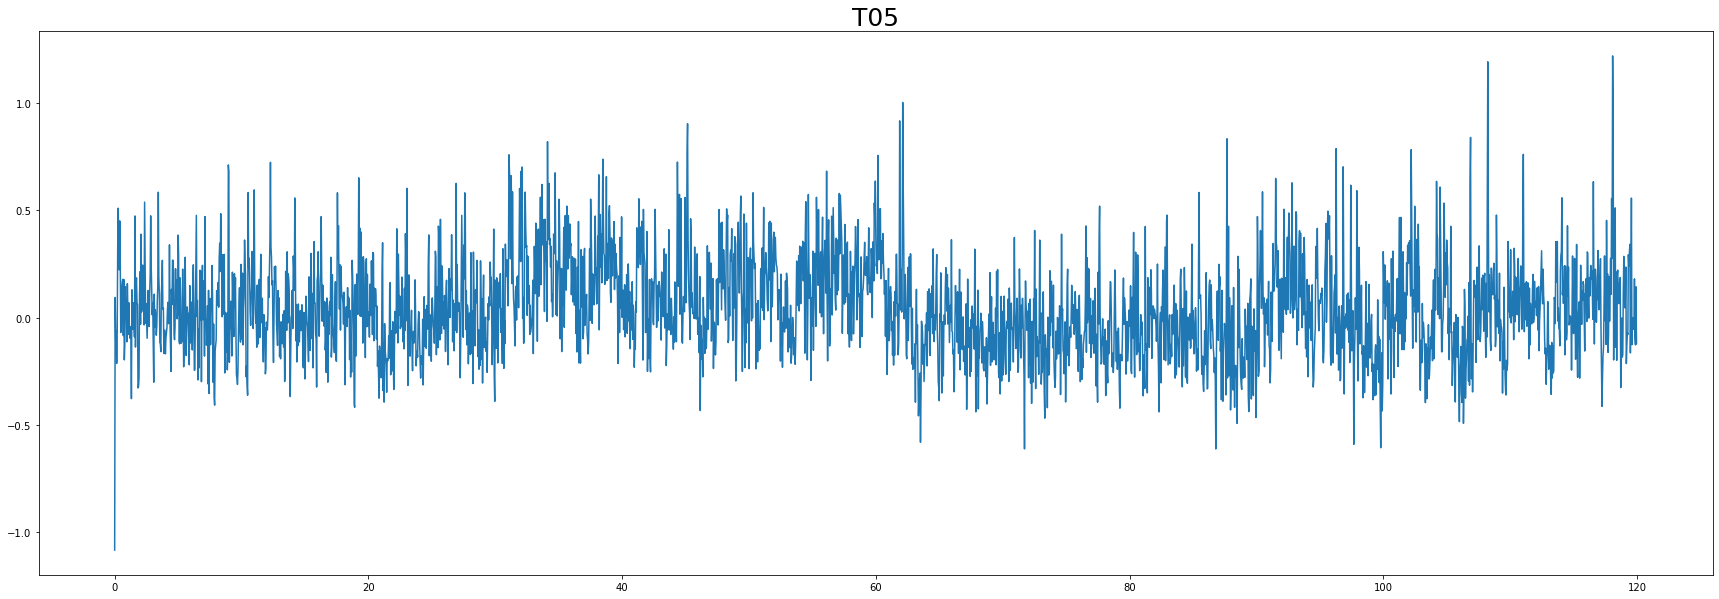

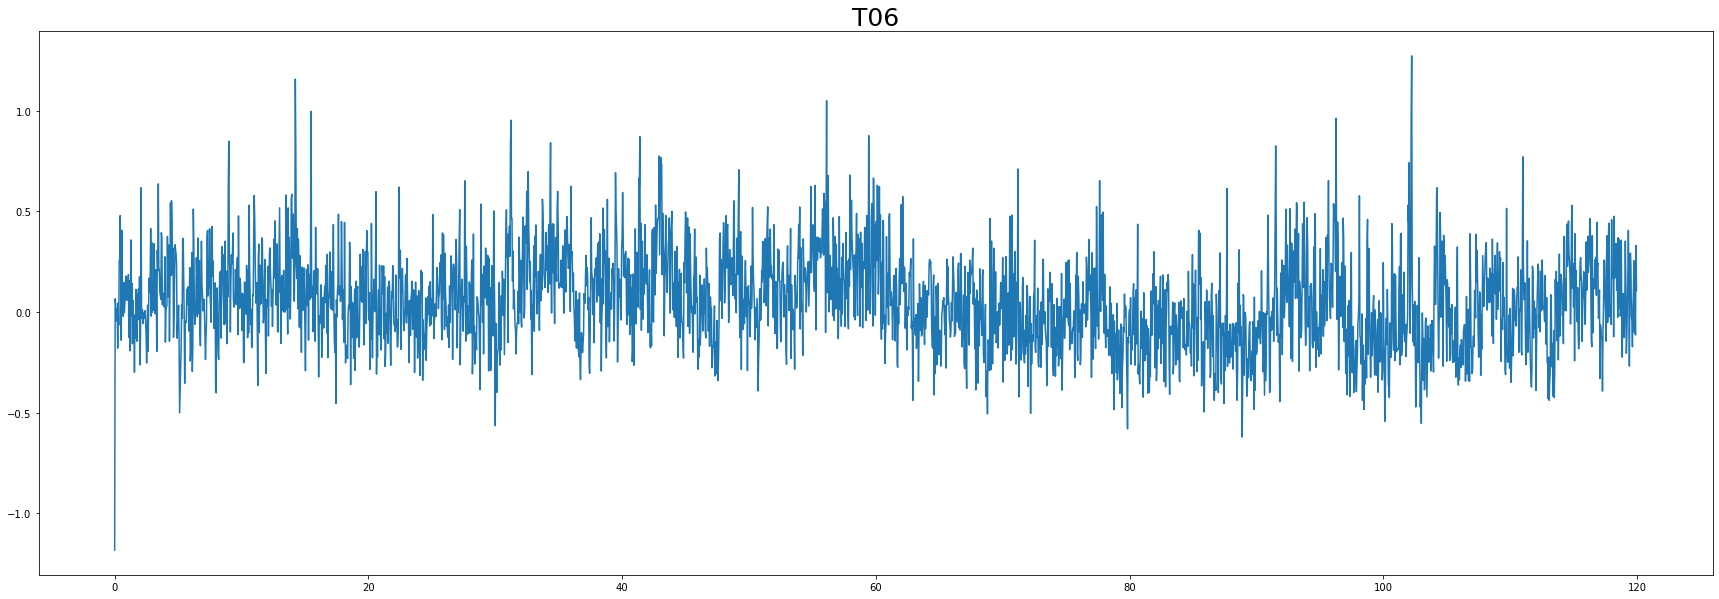

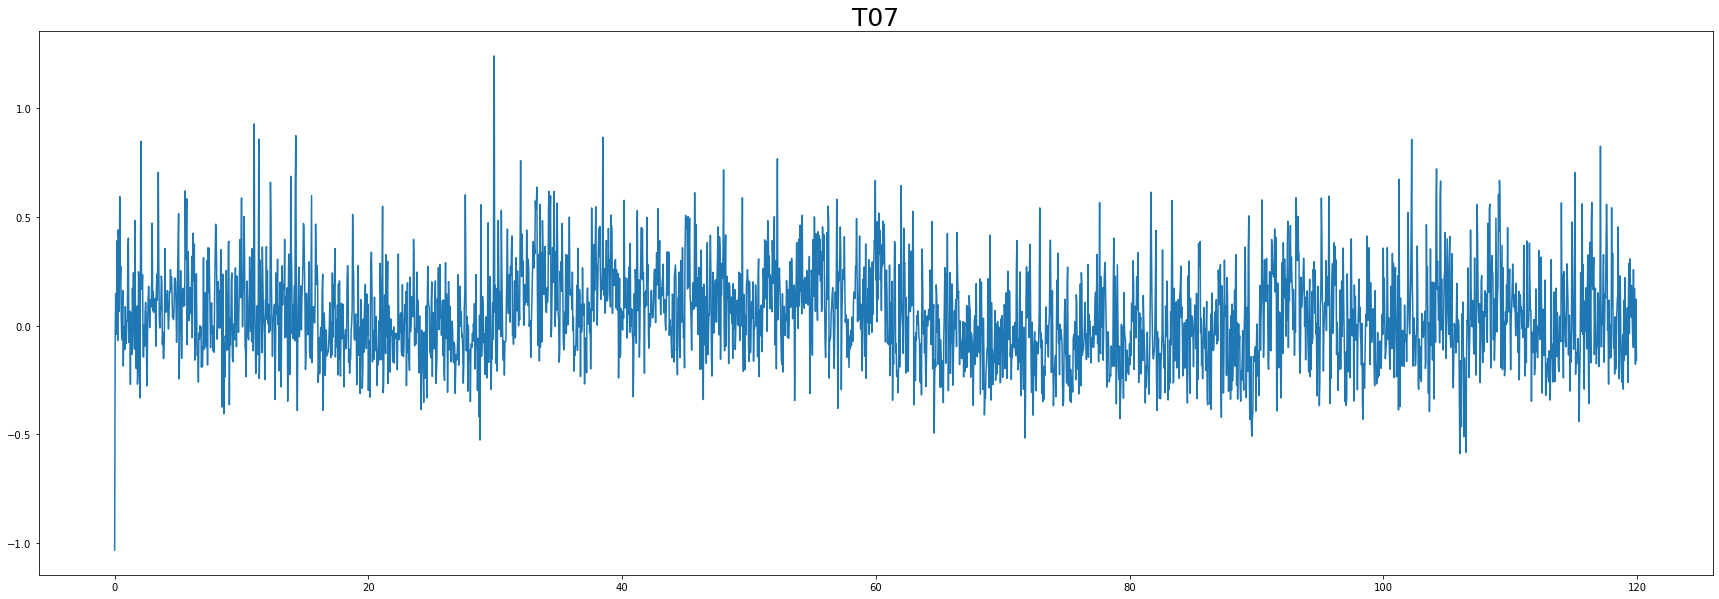

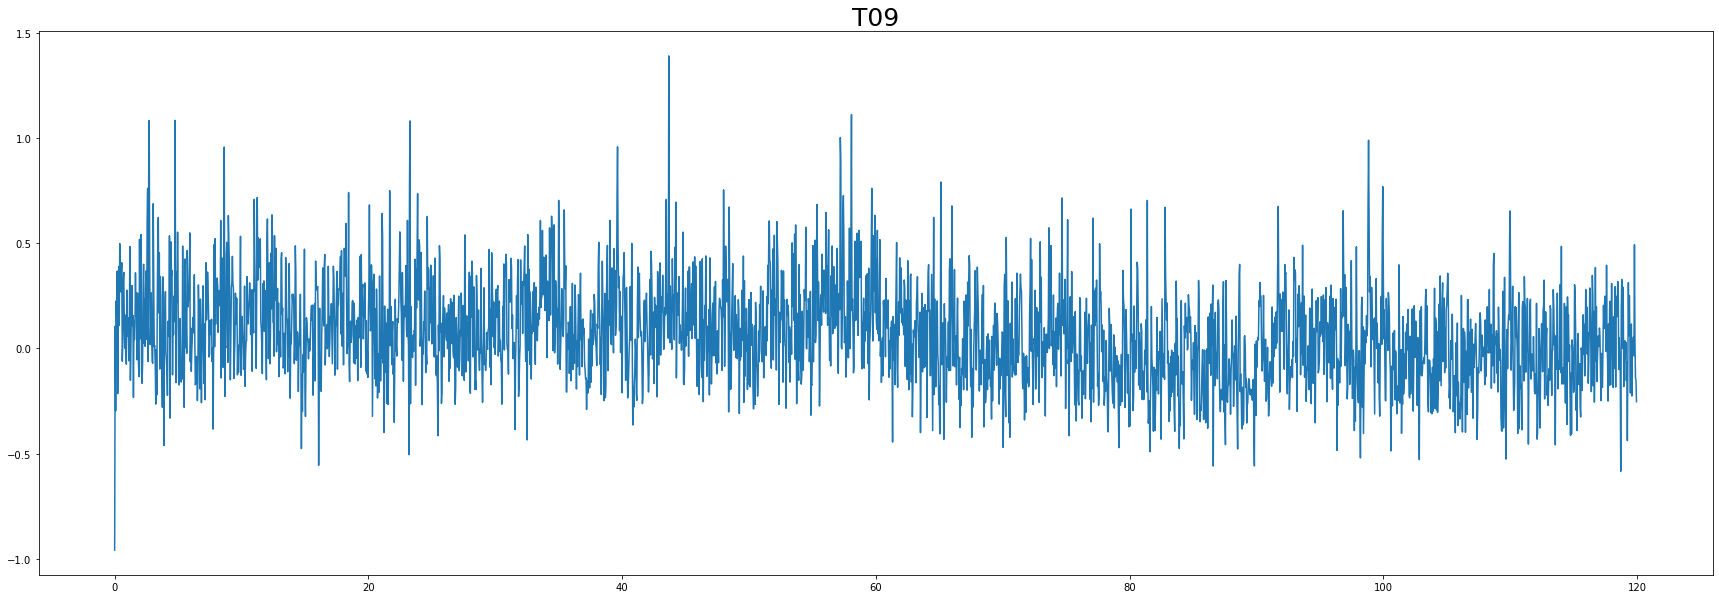

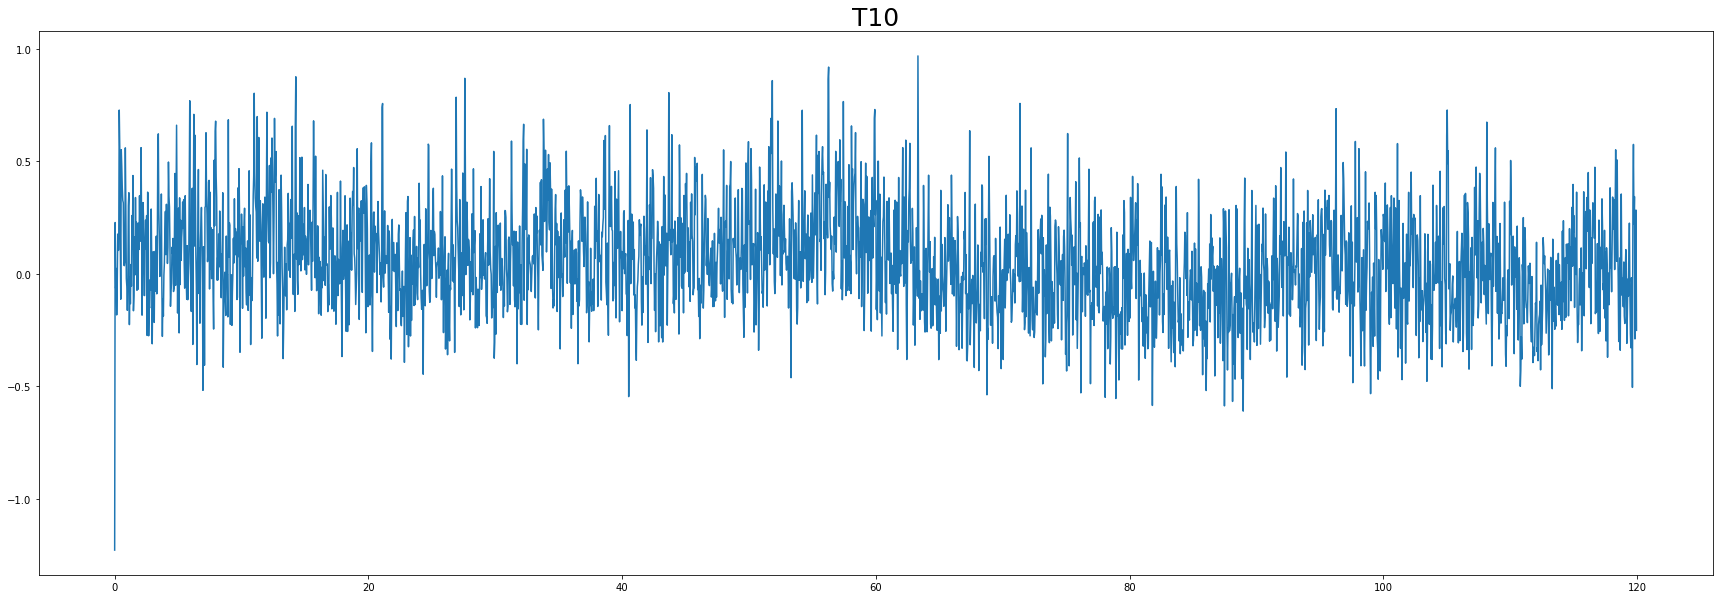

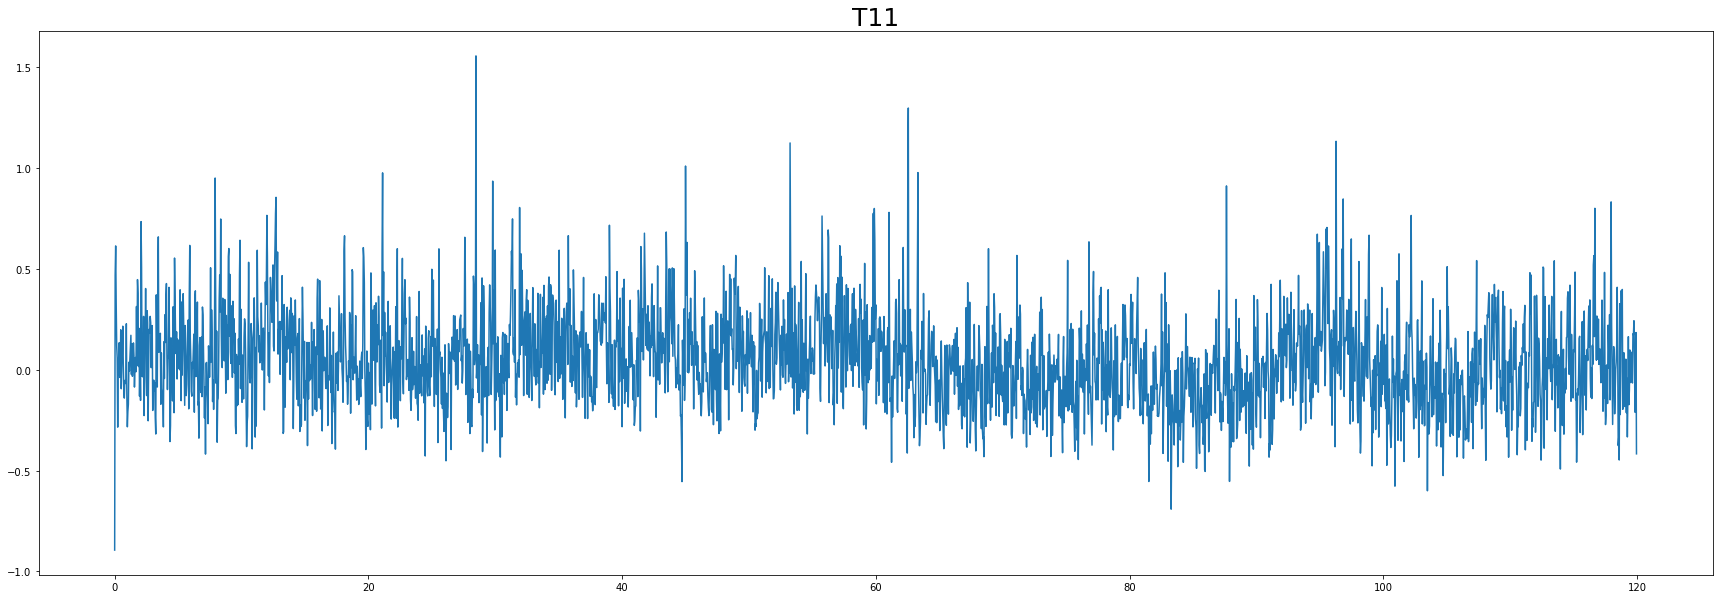

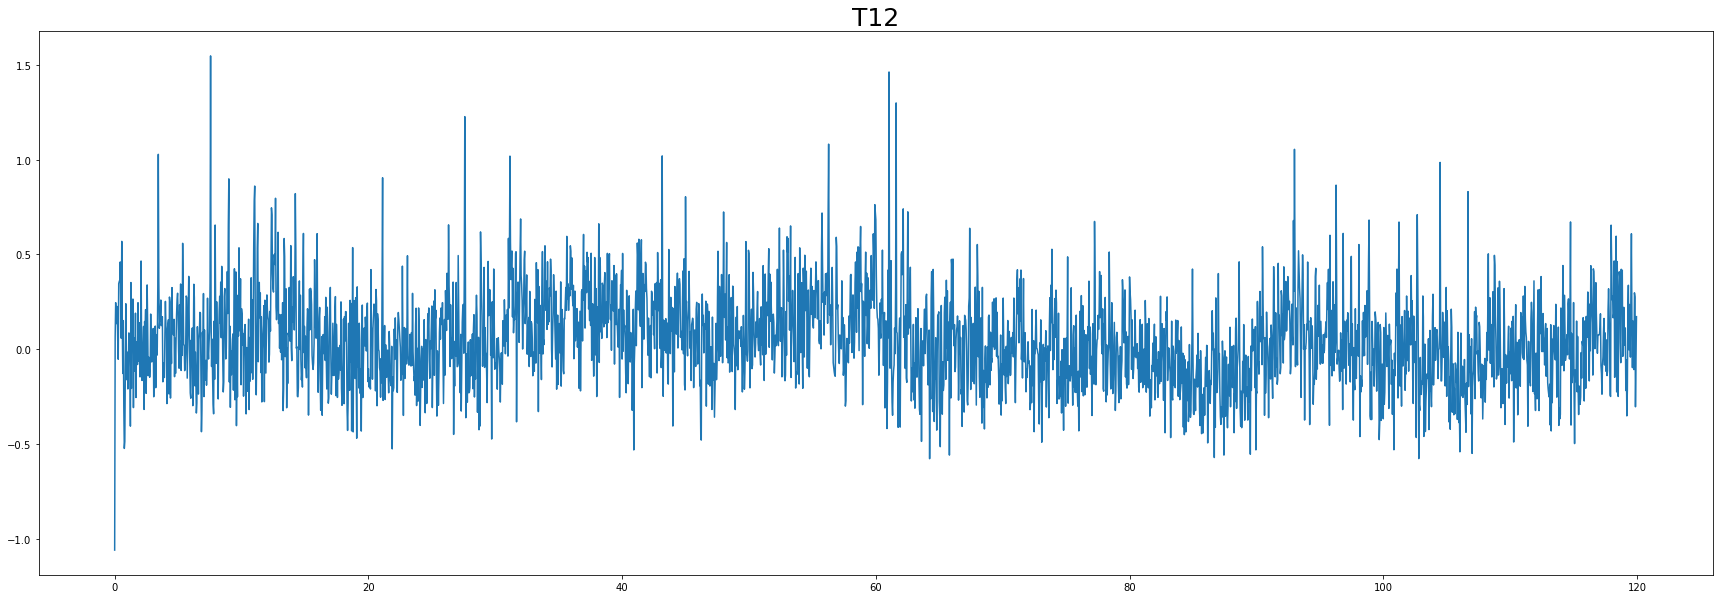

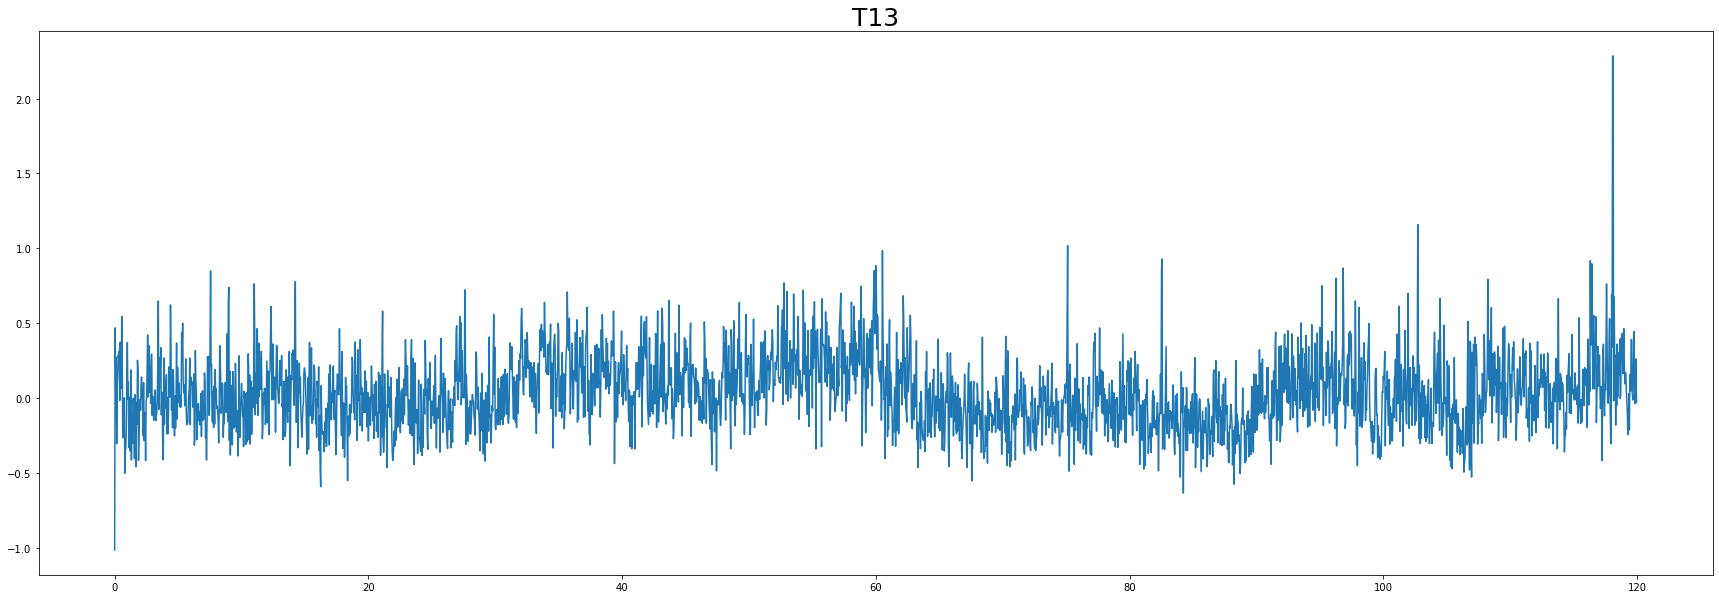

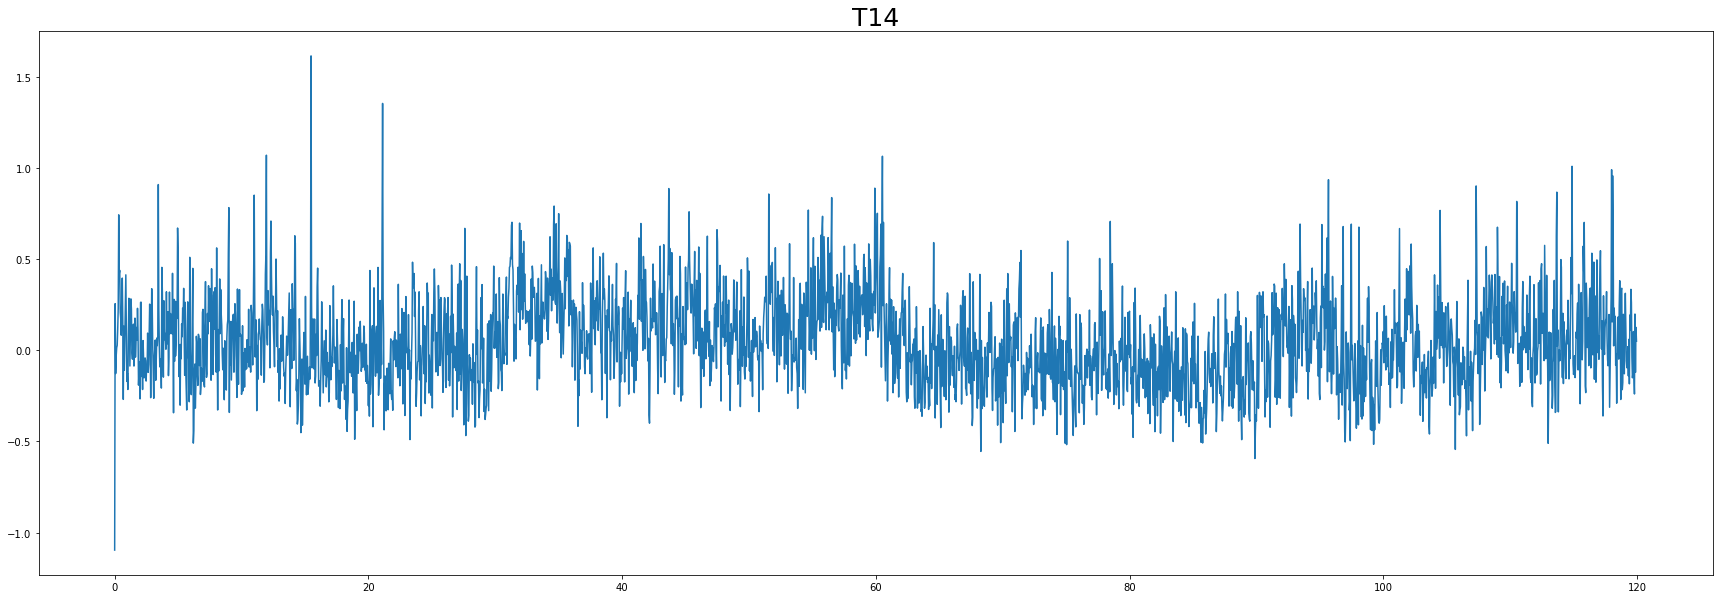

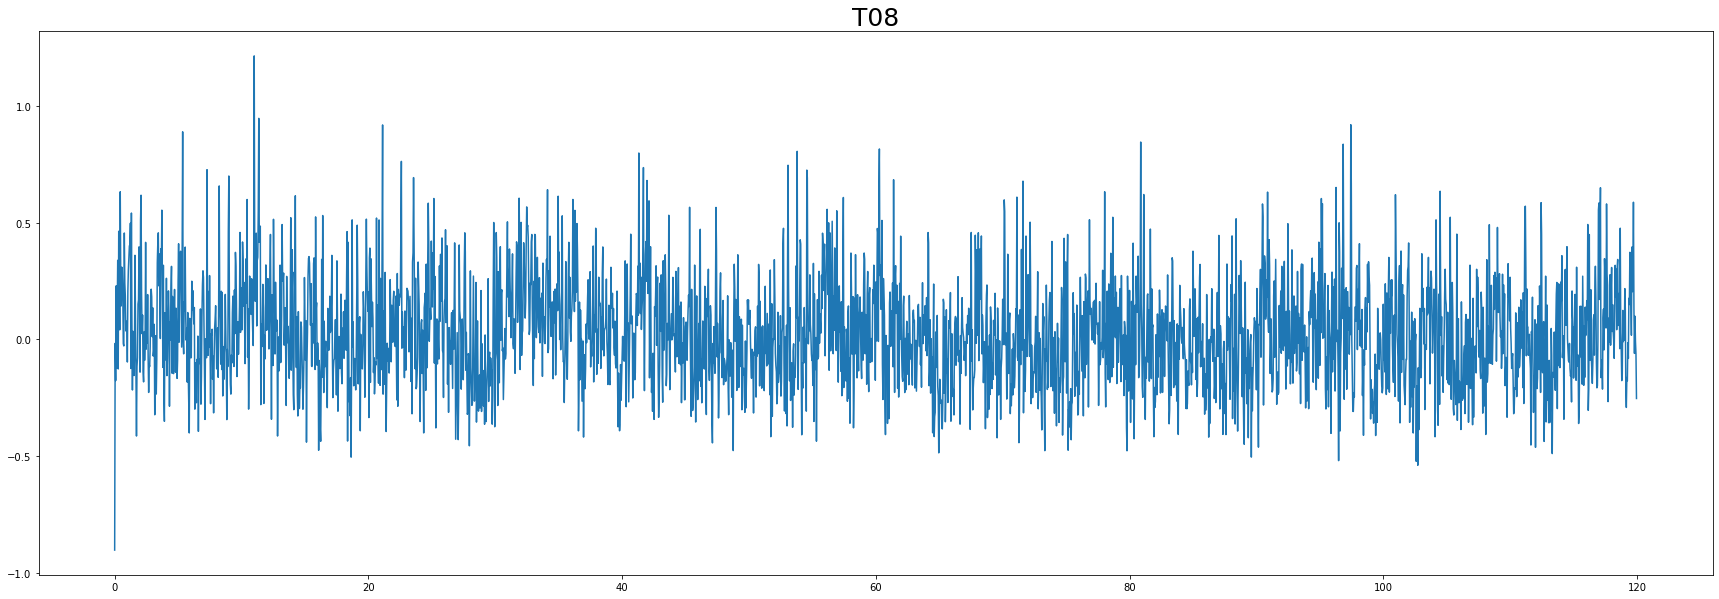

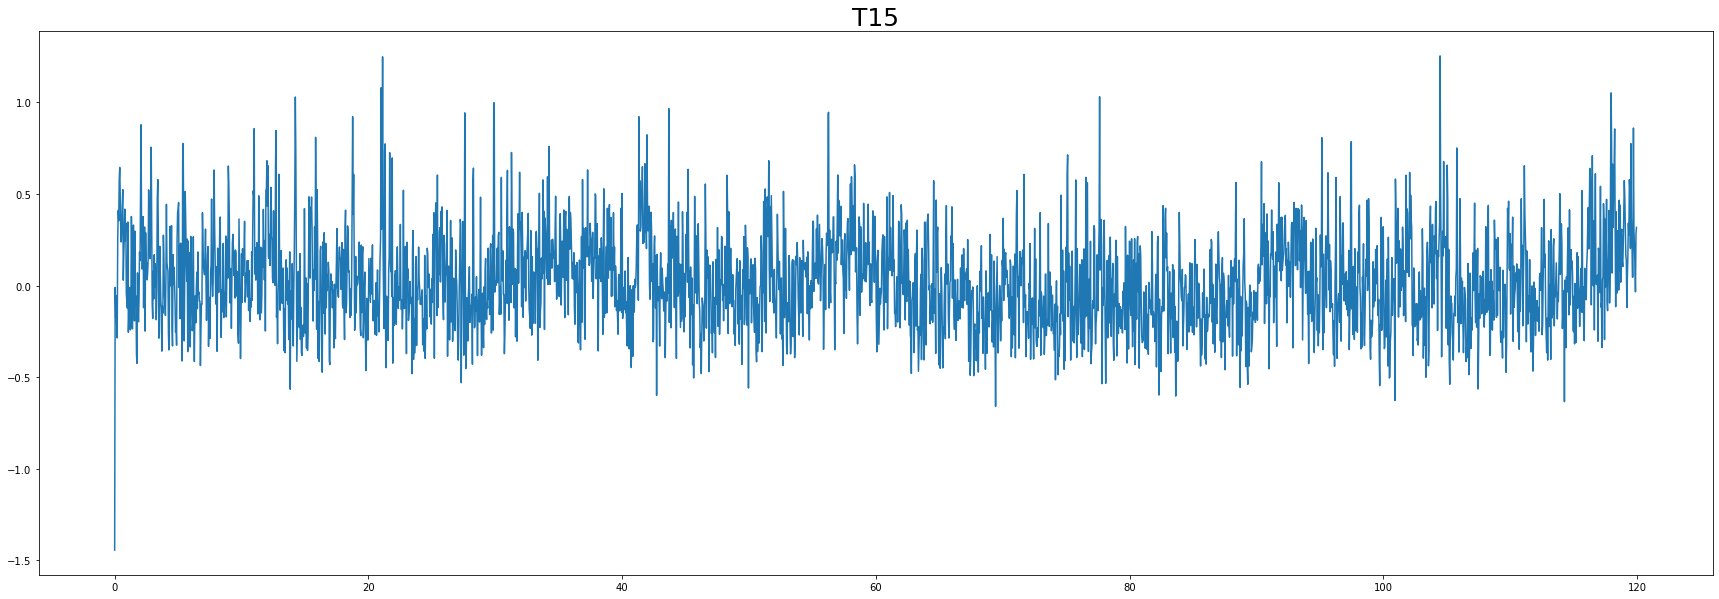

In [166]:
import matplotlib.pyplot as plt
import numpy as np

plot_elec_avg= {'F01':0 , 'F03':0 , 'F05': 0 , 'F06':0 , 'F07':0 , 'F08':0 , 'T01':0 , 'T02':0 , 'T03':0 , 'T04':0 , 'T05':0 , 'T06':0, 'T07':0, 'T09':0, 'T10':0, 'T11':0, 'T12':0 , 'T13':0 , 'T14':0, 'T08':0, 'T15':0}
time=np.arange(0, band_all_patient[0].shape[0])/(25)


for key in plot_elec_avg.keys():
    for i in elec[key]:
        num_electrode=raw_car_all[i].ch_names.index(key)
        plot_elec_avg[key]=plot_elec_avg[key]+band_all_patient[i][:,num_electrode]
    plot_elec_avg[key]=plot_elec_avg[key]/len(elec[key])
    plt.figure(figsize=(30,10))
    plt.plot(time[:120*25],plot_elec_avg[key][:120*25])
    plt.title(str(key),fontsize=25)
    plt.show()
   


### 3-1.plot preprocess data of one patient

Fs = 2048.0
shape of raw_data is = (101, 860254)
time duration is  860254 / 2048.0 = 420.0458984375 s


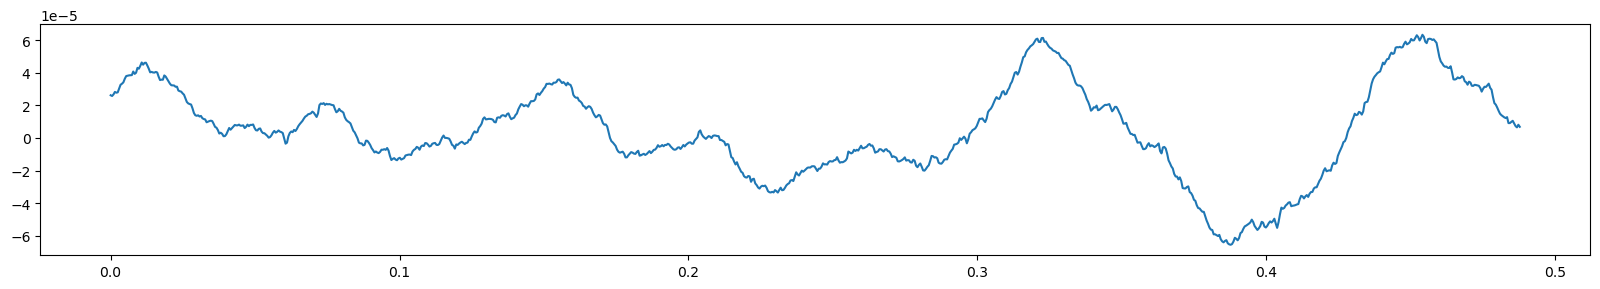

In [13]:
import matplotlib.pyplot as plt
raw_data=raw_car.get_data()
fs = raw_car_all[1].info['sfreq']
time = np.arange(0, raw_car_all[1].shape[1])/(fs)
print('Fs =',fs)
print('shape of raw_data is =', raw_car_all[1].shape)
print('time duration is ',raw_car_all[1].shape[1],'/',fs,'=',raw_car_all[1].shape[1]/fs,'s')


### plot Zscore of HFB band of one electrode

In [93]:
band5.keys()

odict_keys(['delta', 'theta', 'alpha', 'beta', 'gamma'])

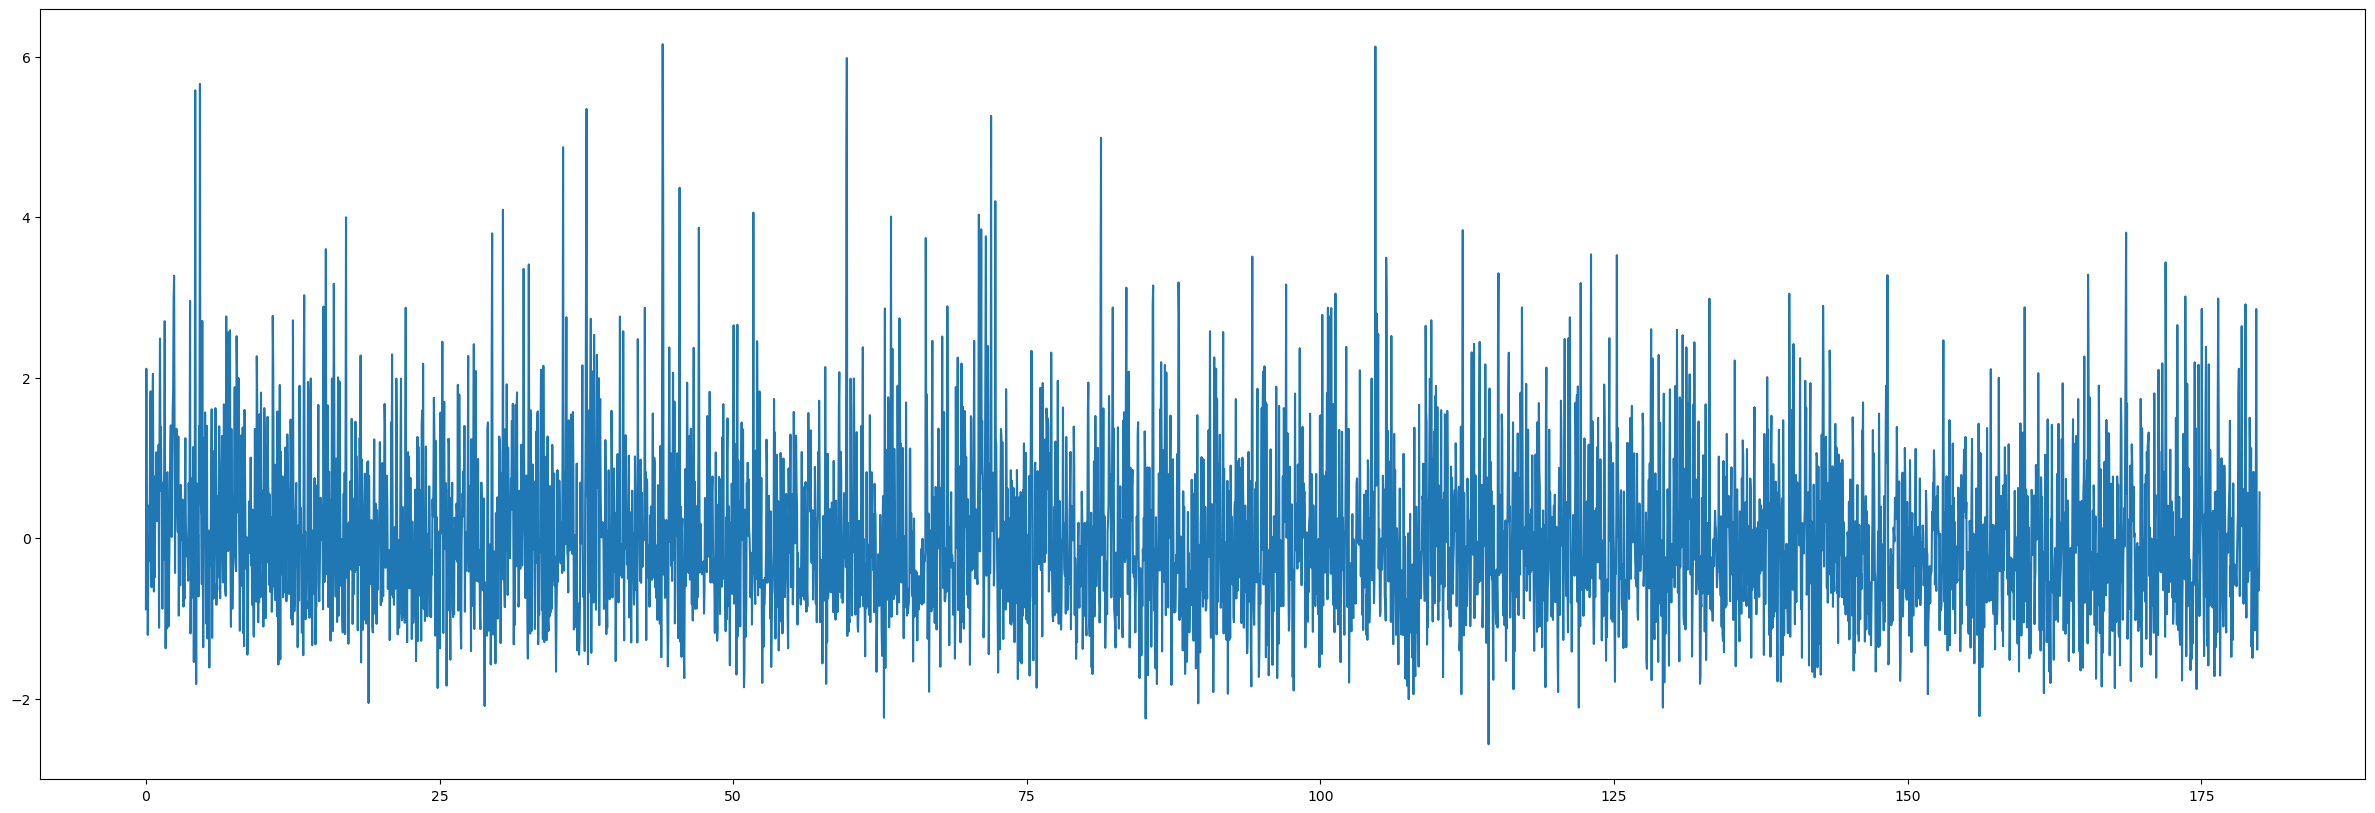

In [8]:
import matplotlib.pyplot as plt

time=np.arange(0, band5['gamma'].shape[0])/(25)
plt.figure(figsize=(30,10))
plt.plot(time[:4500],band5['gamma'][:4500,1])
plt.show()

### plot HFB band of one electrode (without Zscore)

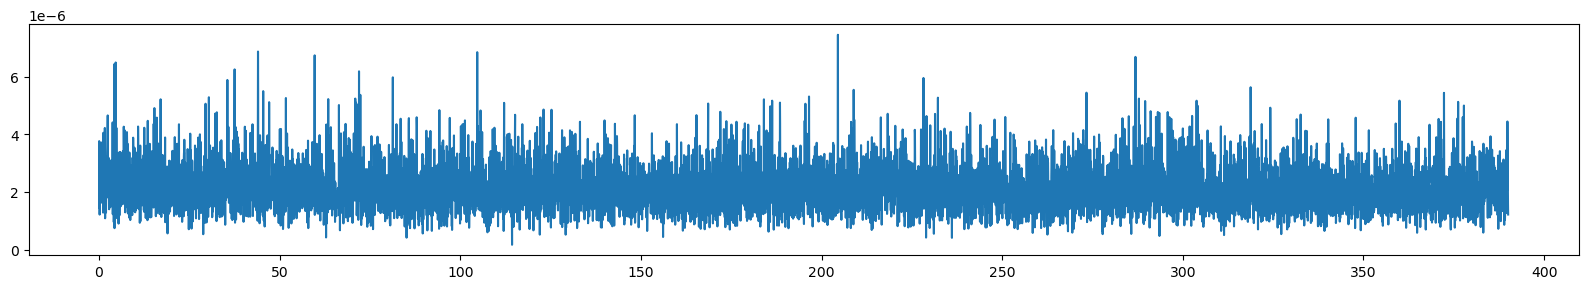

In [10]:
import matplotlib.pyplot as plt

time=np.arange(0, bands4['gamma'].shape[0])/(25)
plt.figure(figsize=(20,3))
plt.plot(time,bands4['gamma'][:,1])
plt.show()

### regression with autoregressive

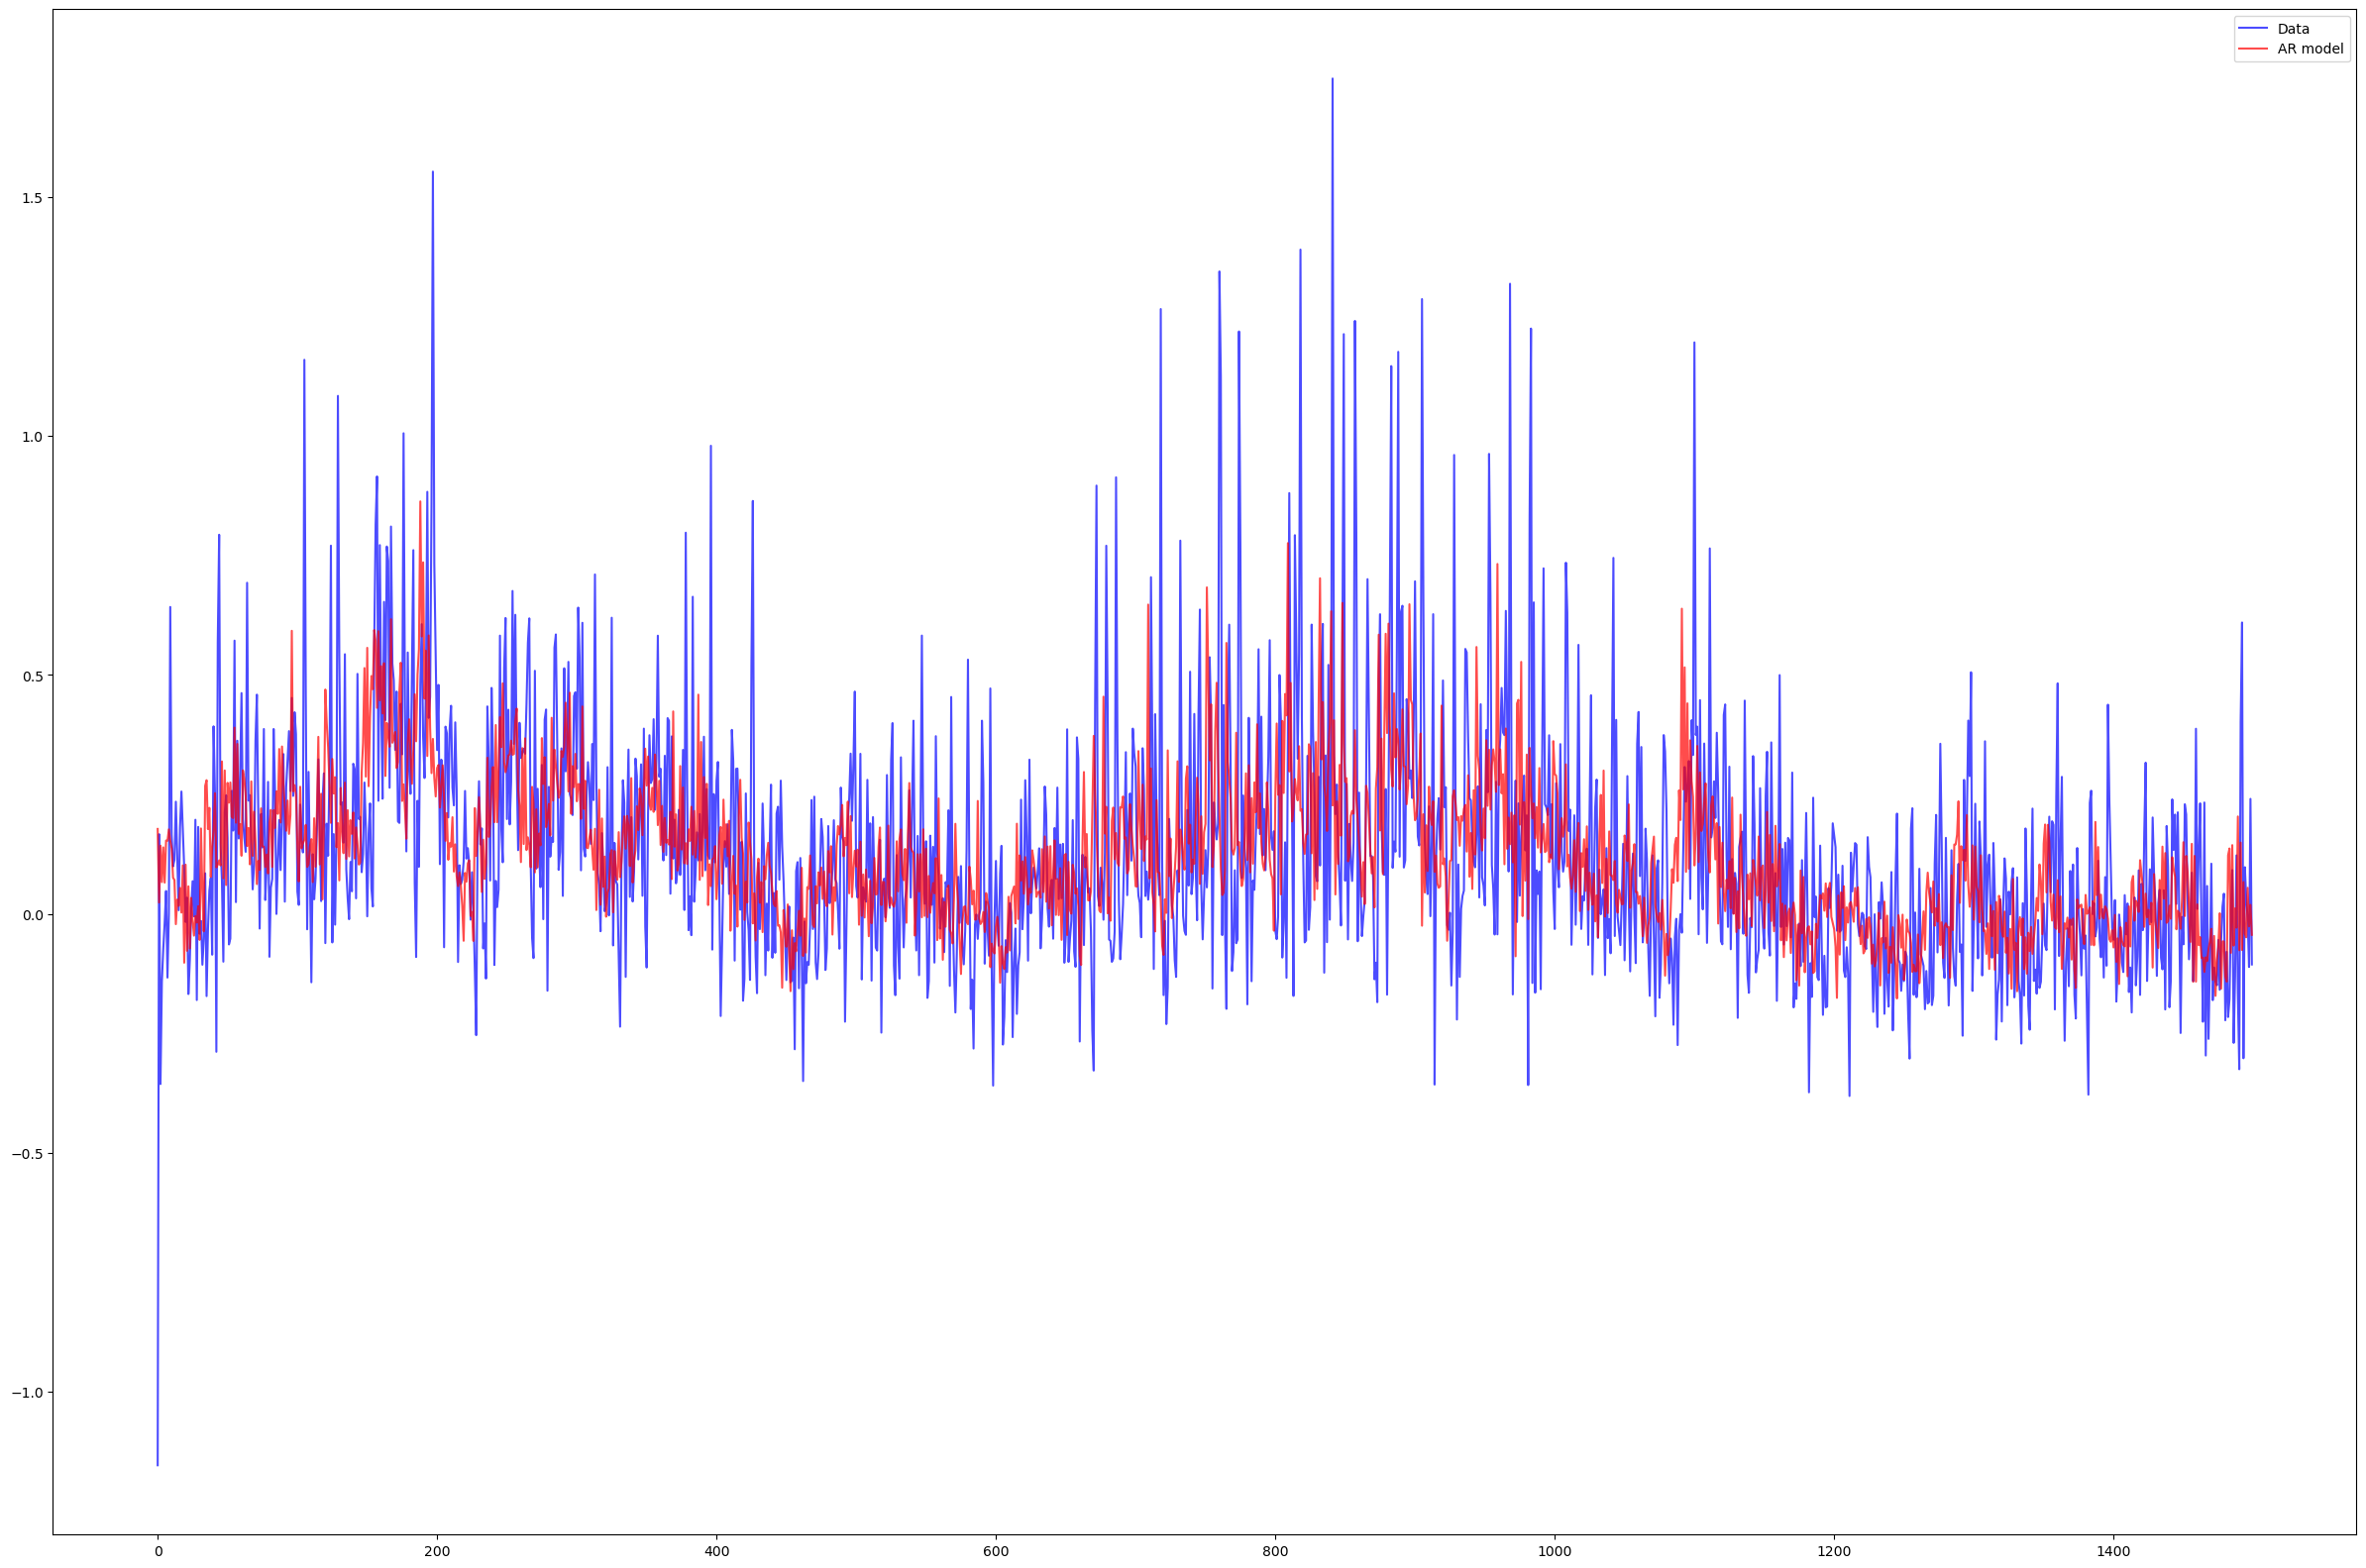

In [12]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AR model
lags = 10
model = AutoReg(bands5_mean_elec,lags = lags)
results = model.fit()

# Create the plot
fig, ax = plt.subplots(figsize=(30, 20))
ax.plot(bands5_mean_elec[:1500], color='blue', alpha=0.7, label='Data')
ax.plot(results.fittedvalues[:1500], color='red', alpha=0.7, label='AR model')
ax.legend()
plt.show()